In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
from openquake.commonlib.datastore import read
from openquake.commonlib.logs import get_calc_ids
import matplotlib.pyplot as plt

In [2]:
EFEHR_FOLDER = Path(r"C:\Users\clemettn\OneDrive - Helmut-Schmidt-Universität\01_arbeit\14_PhD\data\eshm20_hazard_curves\tailfingen_mean_hazard\mafe")

In [3]:
for id in get_calc_ids():
    with read(id) as ds:
        # get calculation parameters
        params = ds["oqparam"]       
        print(f"Calc ID: {id:>4}  |  {params.description}")

Calc ID:    1  |  Classical PSHA — Area Source
Calc ID:    4  |  [Tailfingen (Site Hazard) - ESHM20 v12e main region - 1yr]
Calc ID:   14  |  [Tailfingen (Site Hazard) - ESHM20 v12e main region - 1yr]
Calc ID:   25  |  [Tailfingen (Site Hazard) - ESHM20 v12e main region - 1yr]


In [4]:
calc_id = 25  # hazard and disaggregation
ds = read(calc_id)

# load the SA(0.1) mean hazard from openquake
imt = "SA(0.1)"
time_period = 1
imts = ds['oqparam'].imtls
df = ds.read_df("hcurves-stats")#, "stat":"mean", "site_id":0})
df = df[(df["imt"] == f"{imt}") & (df["stat"] == "mean")]
poes_psha = df["value"].values
imls_psha = ds['oqparam'].imtls[imt]
mafes_psha = -np.log(1-poes_psha) / time_period

# load the data taken from teh EFEHR web portal
efehr_data = np.loadtxt(EFEHR_FOLDER / "SA_0_10s_mean_mafe.csv", delimiter=",", skiprows=1) 
imls_efehr = efehr_data[:,0]
mafes_efehr = efehr_data[:,1]

[2.0077807e-01 1.8116404e-01 1.5970065e-01 1.3765903e-01 1.1622253e-01
 9.6299365e-02 7.8449056e-02 6.2915161e-02 4.9699057e-02 3.8655933e-02
 2.9567655e-02 2.2194918e-02 1.6299944e-02 1.1657813e-02 8.0654761e-03
 5.3493152e-03 3.3640161e-03 1.9824472e-03 1.0809778e-03 5.3897122e-04
 2.4232223e-04 9.6743017e-05 3.3796405e-05 1.0073236e-05 2.5630029e-06]


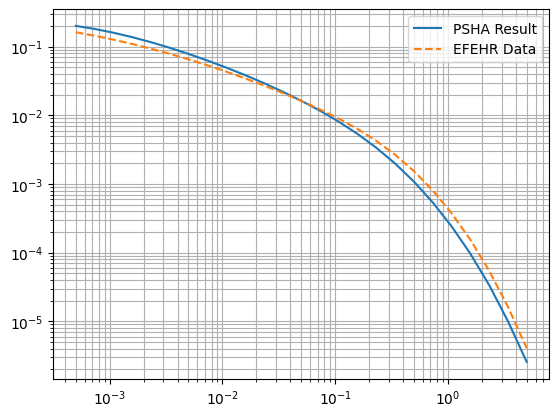

In [5]:
fig, ax = plt.subplots()
print(mafes_psha)
ax.plot(imls_psha, mafes_psha, label="PSHA Result")
ax.plot(imls_efehr, mafes_efehr, ls="--", label="EFEHR Data")
ax.loglog()
ax.grid(True, "both")
ax.minorticks_on()
ax.legend()

In [6]:
list(ds)

['_csm',
 '_disagg_trt',
 '_rates',
 'best_rlzs',
 'disagg-bins',
 'disagg-rlzs',
 'disagg-stats',
 'est_rups_by_grp',
 'full_lt',
 'gsims',
 'hcurves-stats',
 'hmap3',
 'hmaps-stats',
 'oqparam',
 'performance_data',
 'poe4',
 'rup',
 'site_model',
 'sitecol',
 'source_data',
 'source_groups',
 'source_info',
 'source_mags',
 'source_model_read_times',
 'task_info',
 'task_sent',
 'toms',
 'trt_smrs',
 'weights']

In [7]:
# load the dissaggregation results
print(list(ds['disagg-stats']))
disagg = ds['disagg-stats/Mag_Dist_Eps']

# list out the shape information of the disaggregation results
print(f"{'Index':<5} | {'Description':<11} | {'Length':<}")
for ii, descr in enumerate(disagg.attrs["shape_descr"]):
    print(f"{ii:<5} | {descr:<11} | {disagg.shape[ii]}")


['Mag_Dist_Eps']
Index | Description | Length
0     | site_id     | 1
1     | Mag         | 10
2     | Dist        | 20
3     | Eps         | 6
4     | imt         | 17
5     | poe         | 7
6     | Z           | 1


In [8]:
# get the bin tags and middle values
bin_labels = [l for l in list(ds["disagg-bins"]) if l in disagg.attrs["shape_descr"]]
bin_values = {}
for l in bin_labels:
    bin_edges = ds[f"disagg-bins/{l}"][:]
    bin_values[l] = 0.5*(bin_edges[1:] + bin_edges[:-1])

# get the poe values
poes = ds["oqparam"].poes
imts = list(ds["oqparam"].hazard_imtls.keys())

In [9]:
# load the disaggregation csv file:
CSV_FILE = Path(r"C:\Users\clemettn\OneDrive - Helmut-Schmidt-Universität\Desktop\test_output\Mag_Dist_Eps-mean-0_25.csv")
df = pd.read_csv(CSV_FILE, delimiter=",", header=0)
print(df.columns)

# calculate some new columns
df["nu_m"] = -np.log(1 - df["mean"]) / ds["oqparam"].investigation_time
df["1-P(X>x|T,m)"] = 1 - df["mean"]
df["P(X>x|T)"] = 1 - df.groupby(by=["imt", "poe"])["1-P(X>x|T,m)"].transform("prod")
df["nu"] = -np.log(1 - df["P(X>x|T)"]) / ds["oqparam"].investigation_time
df["P(m|X>x)"] = df["nu_m"] / df["nu"]      # this is the traditional PSHA-Disaggregation result

# set the index
df = df.set_index(["imt", "poe", "mag", "dist", "eps"])
df = df.sort_index()

df

Index(['imt', 'iml', 'poe', 'mag', 'dist', 'eps', 'mean'], dtype='object')


iml          mean          nu_m  \
imt     poe    mag  dist  eps                                          
PGA     0.0001 4.75 12.5  -2.5  0.552169  0.000000e+00 -0.000000e+00   
                          -1.5  0.552169  0.000000e+00 -0.000000e+00   
                          -0.5  0.552169  0.000000e+00 -0.000000e+00   
                           0.5  0.552169  2.851780e-07  2.851780e-07   
                           1.5  0.552169  4.191920e-06  4.191929e-06   
...                                  ...           ...           ...   
SA(5.0) 0.0200 9.25 487.5 -1.5  0.000610  0.000000e+00 -0.000000e+00   
                          -0.5  0.000610  0.000000e+00 -0.000000e+00   
                           0.5  0.000610  0.000000e+00 -0.000000e+00   
                           1.5  0.000610  0.000000e+00 -0.000000e+00   
                           2.5  0.000610  0.000000e+00 -0.000000e+00   

                                1-P(X>x|T,m)  P(X>x|T)        nu  P(m|X>x)  
imt     poe    mag  dist  eps                                               
PGA     0.0001 4.75 12.5  -2.5      1.000000  0.000102  0.000102 -0.000000  
                          -1.5      1.000000  0.000102  0.000102 -0.000000  
                          -0.5      1.000000  0.000102  0.000102 -0.000000  
                           0.5      1.000000  0.000102  0.000102  0.002805  
                           1.5      0.999996  0.000102  0.000102  0.041225  
...                                      ...       ...       ...       ...  
SA(5.0) 0.0200 9.25 487.5 -1.5      1.000000  0.020084  0.020289 -0.000000  
                          -0.5      1.000000  0.020084  0.020289 -0.000000  
                           0.5      1.000000  0.020084  0.020289 -0.000000  
                           1.5      1.000000  0.020084  0.020289 -0.000000  
                           2.5      1.000000  0.020084  0.020289 -0.000000  

[142800 rows x 7 columns]

In [10]:
# Example assuming you've already loaded the dataset
data = disagg[:]

# Create consistent index arrays
idx = np.indices(data.shape)

# Flatten everything in matching order
coords = [i.ravel() for i in idx]
values = data.ravel()

# Build DataFrame
df = pd.DataFrame({
    "site_id": coords[0],
    "Mag": coords[1],
    "Dist": coords[2],
    "Eps": coords[3],
    "imt": coords[4],
    "poe": coords[5],
    "Z": coords[6],
    "value": values
})

# replace the index values from data store with mapped values
for l, v in bin_values.items(): 
    mapping = {ov:nv for ov, nv in enumerate(v)}
    df[l] = df[l].map(mapping)

mapping = {ov:nv for ov, nv in enumerate(poes)}
df["poe"] = df["poe"].map(mapping)

mapping = {ov:nv for ov, nv in enumerate(imts)}
df["imt"] = df["imt"].map(mapping)

# remove the unneeded site_id and Z columns
df = df.drop(columns=["site_id", "Z"])

# rename columns
df = df.rename(columns={"Mag":"mag", "Dist":"dist", "Eps":"eps", "value":"P(X>x|T,m)"}, errors="ignore")

# calculate some new columns
df["nu_m"] = -np.log(1 - df["P(X>x|T,m)"]) / ds["oqparam"].investigation_time
df["1-P(X>x|T,m)"] = 1 - df["P(X>x|T,m)"]
df["P(X>x|T)"] = 1 - df.groupby(by=["imt", "poe"])["1-P(X>x|T,m)"].transform("prod")
df["nu"] = -np.log(1 - df["P(X>x|T)"]) / ds["oqparam"].investigation_time
df["P(m|X>x)"] = df["nu_m"] / df["nu"]      # this is the traditional PSHA-Disaggregation result

# set the index
df = df.set_index(["imt", "poe", "mag", "dist", "eps"])
df = df.sort_index()

In [11]:
print("poes:", poes)
print("imts:", list(ds["oqparam"].hazard_imtls.keys()))

poes: [0.02, 0.00989, 0.002103, 0.0010249, 0.000399999, 0.00019999, 0.0001]
imts: ['PGA', 'SA(0.05)', 'SA(0.15)', 'SA(0.25)', 'SA(0.35)', 'SA(0.75)', 'SA(0.1)', 'SA(0.2)', 'SA(0.3)', 'SA(0.4)', 'SA(0.5)', 'SA(0.6)', 'SA(1.0)', 'SA(2.0)', 'SA(3.0)', 'SA(4.0)', 'SA(5.0)']


In [12]:
# choose poe and imt to plot
poe = 0.002103
imt = "PGA"
disagg_type = "P(m|X>x)" # "P(X>x|T,m)" (Openquake Default) or "P(m|X>x)" (Traditional)
df_imt_poe = df.loc[imt, poe]

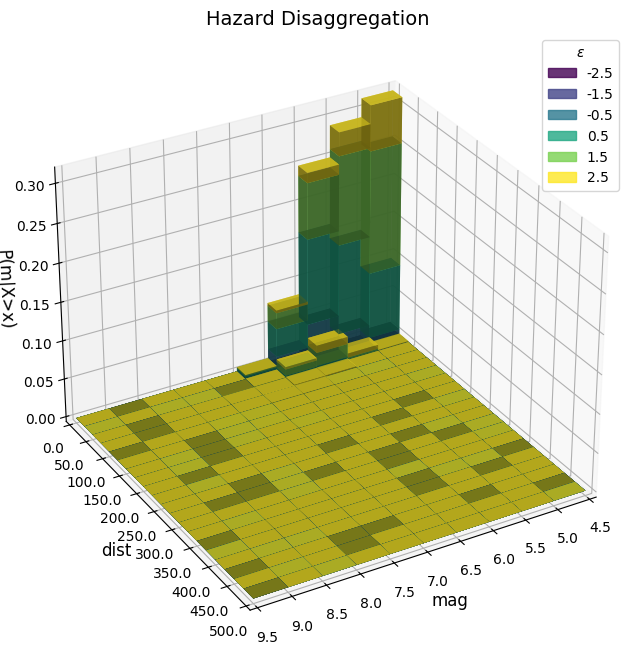

In [13]:
# Convert the MultiIndex into regular columns
df_plot = df_imt_poe.reset_index()

# Bar properties
dz = df_plot[disagg_type]        # The height of eac bar segment bar
dx = ds["oqparam"].mag_bin_width                     # Bar width in the X direction
dy = ds["oqparam"].distance_bin_width                    # Bar depth in the Y direction


df_plot['Z_TOP'] = df_plot.groupby(['mag', 'dist'])[disagg_type].cumsum()   # top of each bar segment
df_plot['Z_POS'] = df_plot['Z_TOP'] - df_plot[disagg_type]                  # the bottom of each bar segment

x_pos = df_plot["mag"] - dx/2
y_pos = df_plot["dist"] - dy/2
z_pos = df_plot['Z_POS'] # All bars start at z=0

# 3. PLOTTING: Create the 3D Bar Chart
# ------------------------------------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define a color map for the 3rd index level ('eps')
colors = plt.cm.viridis(np.linspace(0, 1, len(df_plot['eps'].unique())))
color_map = {label: colors[i] for i, label in enumerate(df_plot['eps'].unique())}
plot_colors = [color_map[t] for t in df_plot['eps']]

# The core plotting function: ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz)
ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, color=plot_colors, alpha=0.8)

# 4. AXIS CUSTOMIZATION: Set Labels and Ticks
# ------------------------------------------

# Set the tick positions and labels using the original categorical values
ax.set_xticks(ds["disagg-bins/Mag"])
ax.set_xticklabels(ds["disagg-bins/Mag"])

ax.set_yticks(ds["disagg-bins/Dist"][::2])
ax.set_yticklabels(ds["disagg-bins/Dist"][::2])
# ax.set_yticks(dist_values)
# ax.set_yticklabels(dist_values)

# Set final labels
ax.set_xlabel(df_plot.columns[0], fontsize=12) # Level 0 Index Name
ax.set_ylabel(df_plot.columns[1], fontsize=12) # Level 1 Index Name
ax.set_zlabel(f'{disagg_type}', fontsize=12)
ax.set_title(f'Hazard Disaggregation', fontsize=14)

ax.set_xlim(4.5,9.5)
ax.set_ylim(0,500)

# Create a custom legend based on the 'Type' index level
from matplotlib.patches import Patch
legend_handles = [Patch(color=color_map[t], label=f'{t}', alpha=0.8)
                  for t in sorted(df_plot['eps'].unique())]
ax.legend(handles=legend_handles, title=r"$\varepsilon$", loc='upper right')

# Set the view angle (optional, makes it easier to see)
ax.view_init(elev=30, azim=60)

In [14]:
df

P(X>x|T,m)          nu_m  1-P(X>x|T,m)  \
imt     poe    mag  dist  eps                                              
PGA     0.0001 4.75 12.5  -2.5  0.000000e+00 -0.000000e+00      1.000000   
                          -1.5  0.000000e+00 -0.000000e+00      1.000000   
                          -0.5  0.000000e+00 -0.000000e+00      1.000000   
                           0.5  2.851777e-07  2.851778e-07      1.000000   
                           1.5  4.191921e-06  4.191929e-06      0.999996   
...                                      ...           ...           ...   
SA(5.0) 0.0200 9.25 487.5 -1.5  0.000000e+00 -0.000000e+00      1.000000   
                          -0.5  0.000000e+00 -0.000000e+00      1.000000   
                           0.5  0.000000e+00 -0.000000e+00      1.000000   
                           1.5  0.000000e+00 -0.000000e+00      1.000000   
                           2.5  0.000000e+00 -0.000000e+00      1.000000   

                                P(X>x|T)        nu  P(m|X>x)  
imt     poe    mag  dist  eps                                 
PGA     0.0001 4.75 12.5  -2.5  0.000102  0.000102 -0.000000  
                          -1.5  0.000102  0.000102 -0.000000  
                          -0.5  0.000102  0.000102 -0.000000  
                           0.5  0.000102  0.000102  0.002805  
                           1.5  0.000102  0.000102  0.041225  
...                                  ...       ...       ...  
SA(5.0) 0.0200 9.25 487.5 -1.5  0.020084  0.020289 -0.000000  
                          -0.5  0.020084  0.020289 -0.000000  
                           0.5  0.020084  0.020289 -0.000000  
                           1.5  0.020084  0.020289 -0.000000  
                           2.5  0.020084  0.020289 -0.000000  

[142800 rows x 6 columns]

In [ ]:

M_50

5.25

In [26]:
cumP

mag
4.75    0.314661
5.25    0.612622
5.75    0.894368
6.25    0.991528
6.75    0.999267
7.25    0.999909
7.75    1.000000
8.25    1.000000
8.75    1.000000
9.25    1.000000
Name: P(m|X>x), dtype: float64

In [ ]:
# calculate the mean values of M, R, and epsilon
df_M = df_imt_poe.groupby(level="mag").sum()
M_bar = np.sum(df_M["P(m|X>x)"].values * df_M.index.values)
M_mode = df_M["P(m|X>x)"].idxmax()
cumP = df_M.sort_index(level="mag", ascending=True)["P(m|X>x)"].cumsum()
M_50 = cumP.loc[cumP > 0.5].index.values[0]

df_R = df_imt_poe.groupby(level="dist").sum()
R_bar = np.sum(df_R["P(m|X>x)"].values * df_R.index.values)
R_mode = df_R["P(m|X>x)"].idxmax()
cumR = df_R.sort_index(level="dist", ascending=True)["P(m|X>x)"].cumsum()
R_50 = cumR.loc[cumR > 0.5].index.values[0]

df_eps = df_imt_poe.groupby(level="eps").sum()
eps_bar = np.sum(df_eps["P(m|X>x)"].values * df_eps.index.values)
eps_mode = df_eps["P(m|X>x)"].idxmax()
cumEps = df_eps.sort_index(level="eps", ascending=True)["P(m|X>x)"].cumsum()
eps_50 = cumEps.loc[cumEps > 0.5].index.values[0]

print(f"{'Var.':<4} | {'Mean':<5} | {'Median':<6} | {'Mode':<5}")
print(f"{'M':<4} | {M_bar:<5.2f} | {M_50:<6} | {M_mode:<5.2f}")
print(f"{'R':<4} | {R_bar:<5.1f} | {R_50:<6} | {R_mode:<5.1f}")
print(f"{r'e':<4} | {eps_bar:<5.2f} | {eps_50:<6} | {eps_mode:<5.2f}")

Var. | Mean  | Median | Mode 
M    | 5.34  | 5.25   | 4.75 
R    | 14.3  | 12.5   | 12.5 
e    | 1.06  | 1.5    | 1.50 
